In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from windrose import WindroseAxes


In [2]:

# Definir la ubicación y el período
LAT, LON = -25.2637, -57.5759  # Asunción, Paraguay
START, END = "2019-01-01", "2023-12-31"



In [3]:
# Consultar datos del portal de NASA POWER
url = f"https://power.larc.nasa.gov/api/temporal/hourly/point?parameters=WS10M,WD10M&community=RE&longitude={LON}&latitude={LAT}&start={START.replace('-', '')}&end={END.replace('-', '')}&format=JSON"
data = requests.get(url).json()

In [5]:

# Convertir a DataFrame
df = pd.DataFrame(data['properties']['parameter']['WS10M'].items(), columns=['timestamp', 'wind_speed'])
df['wind_direction'] = df['timestamp'].map(data['properties']['parameter']['WD10M'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df.set_index('timestamp', inplace=True)



In [6]:
df.head()

,wind_speed,wind_direction
timestamp,,
2019-01-01 00:00:00,2.17,24.2
2019-01-01 01:00:00,2.07,16.9
2019-01-01 02:00:00,2.05,16.1
2019-01-01 03:00:00,2.08,20.0
2019-01-01 04:00:00,2.22,26.2


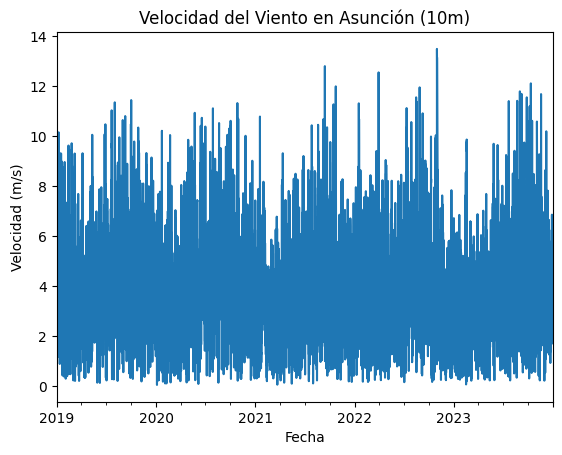

In [7]:

# Análisis exploratorio
df['wind_speed'].plot(title='Velocidad del Viento en Asunción (10m)')
plt.xlabel('Fecha')
plt.ylabel('Velocidad (m/s)')
plt.show()



C:\Users\yoda\AppData\Local\Temp\ipykernel_21260\1322666060.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M').mean()['wind_speed'].plot(title='Promedio Mensual de Velocidad del Viento')


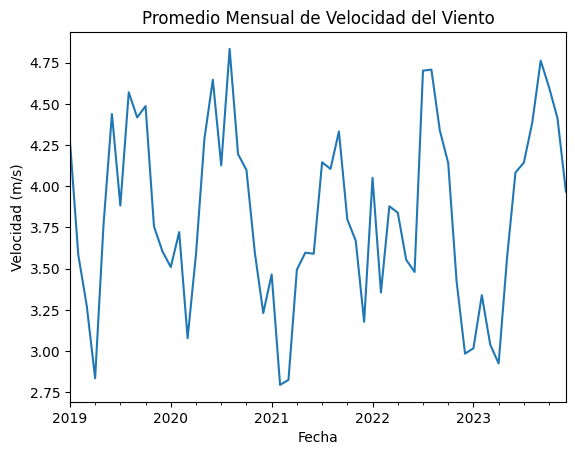

In [8]:
# Estacionalidad: promedio mensual
df.resample('M').mean()['wind_speed'].plot(title='Promedio Mensual de Velocidad del Viento')
plt.xlabel('Fecha')
plt.ylabel('Velocidad (m/s)')
plt.show()


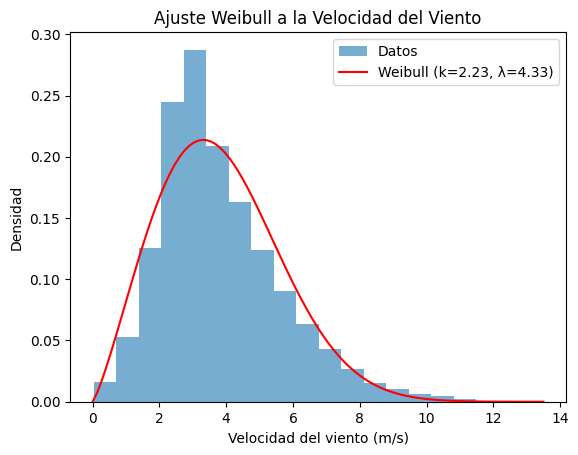

In [9]:
# Ajuste de Weibull
shape, loc, scale = weibull_min.fit(df['wind_speed'], floc=0)
x = np.linspace(0, df['wind_speed'].max(), 100)
pdf = weibull_min.pdf(x, shape, loc, scale)
plt.hist(df['wind_speed'], bins=20, density=True, alpha=0.6, label='Datos')
plt.plot(x, pdf, 'r-', label=f'Weibull (k={shape:.2f}, λ={scale:.2f})')
plt.title('Ajuste Weibull a la Velocidad del Viento')
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [10]:

# Extrapolación a mayor altura usando la ley de potencia (α ≈ 0.14 para terrenos urbanos)
def extrapolate_wind_speed(v10, h1=10, h2=50, alpha=0.14):
    return v10 * (h2 / h1) ** alpha

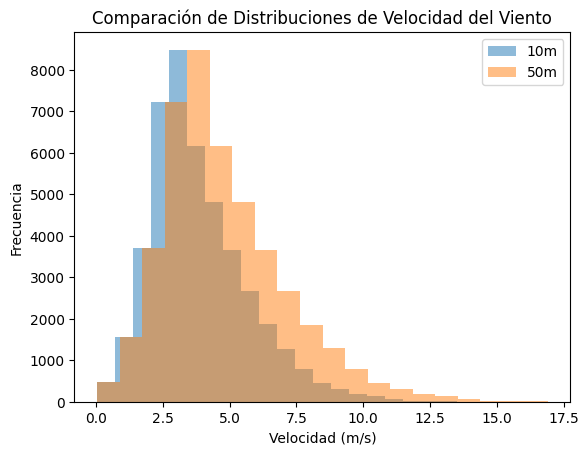

In [11]:

df['wind_speed_50m'] = extrapolate_wind_speed(df['wind_speed'])

# Gráfica de comparación
plt.figure()
plt.hist(df['wind_speed'], bins=20, alpha=0.5, label='10m')
plt.hist(df['wind_speed_50m'], bins=20, alpha=0.5, label='50m')
plt.title('Comparación de Distribuciones de Velocidad del Viento')
plt.xlabel('Velocidad (m/s)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()